In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("stroke_prediction_cleaned.csv")
X = df.iloc[:,1:15]    #ignoring Id 
y = df['stroke']

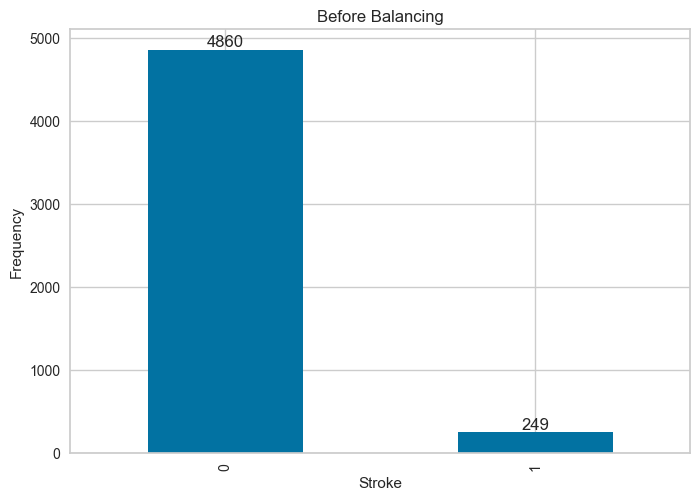

In [3]:
df['stroke'].value_counts().plot(kind='bar')
count = df['stroke'].value_counts()
for x, c in enumerate(count.index):
    plt.text(x, count[c] + 1, str(count[c]), ha='center', va='bottom')

plt.title("Before Balancing")
plt.xlabel("Stroke")
plt.ylabel("Frequency")
plt.show()

In [4]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [5]:
resampled_df = pd.concat([X_resampled, y_resampled], axis=1)

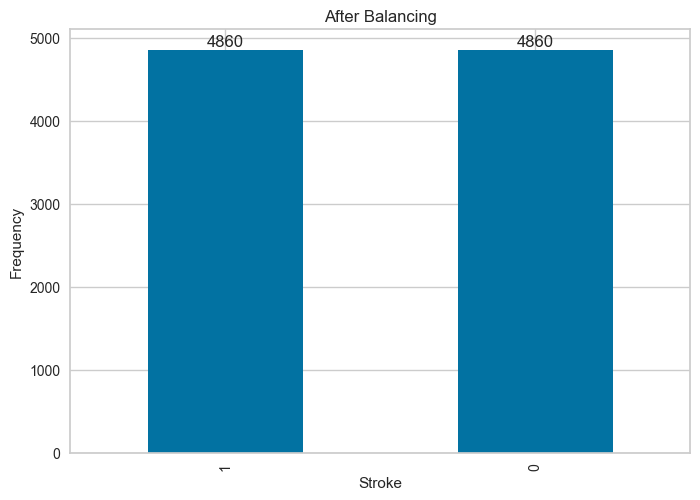

In [6]:
resampled_df['stroke'].value_counts().plot(kind='bar')
count = resampled_df['stroke'].value_counts()
for x, c in enumerate(count.index):
    plt.text(x, count[c] + 1, str(count[c]), ha='center', va='bottom')

plt.title("After Balancing")
plt.xlabel("Stroke")
plt.ylabel("Frequency")
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7776, 14)
(1944, 14)
(7776,)
(1944,)


In [8]:
# 1 - Naive Bayes Model
naive_bayes_model = MultinomialNB()

naive_bayes_model.fit(X_train, y_train)
y_pred = naive_bayes_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('***Naive Bayes***\n')
print(f'Accuracy: {round(accuracy,4)}')
print(f'Precision: {round(precision,4)}')
print(f'Recall: {round(recall,4)}')
print(f'F1-score: {round(f1,4)}')
print(f'Confusion matrix:\n {cm}')

***Naive Bayes***

Accuracy: 0.7341
Precision: 0.7082
Recall: 0.7924
F1-score: 0.7479
Confusion matrix:
 [[660 316]
 [201 767]]


In [9]:
# Verifying accuracy on diffrent subset of data to notice variation of accuracy.
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(naive_bayes_model, X_resampled, y_resampled, cv=kf, scoring='accuracy')

for fold, score in enumerate(cross_val_scores, start=1):
    print(f'Cross-Validation Fold {fold}: Accuracy = {round(score,4)}')
    
mean_score = cross_val_scores.mean()
std_deviation = cross_val_scores.std()
print(f'\nMean Accuracy: {round(mean_score,4)}')
print(f'Standard Deviation: {round(std_deviation,4)}')

Cross-Validation Fold 1: Accuracy = 0.749
Cross-Validation Fold 2: Accuracy = 0.7233
Cross-Validation Fold 3: Accuracy = 0.7613
Cross-Validation Fold 4: Accuracy = 0.7459
Cross-Validation Fold 5: Accuracy = 0.7335
Cross-Validation Fold 6: Accuracy = 0.7541
Cross-Validation Fold 7: Accuracy = 0.7325
Cross-Validation Fold 8: Accuracy = 0.7212
Cross-Validation Fold 9: Accuracy = 0.749
Cross-Validation Fold 10: Accuracy = 0.7582

Mean Accuracy: 0.7428
Standard Deviation: 0.0135


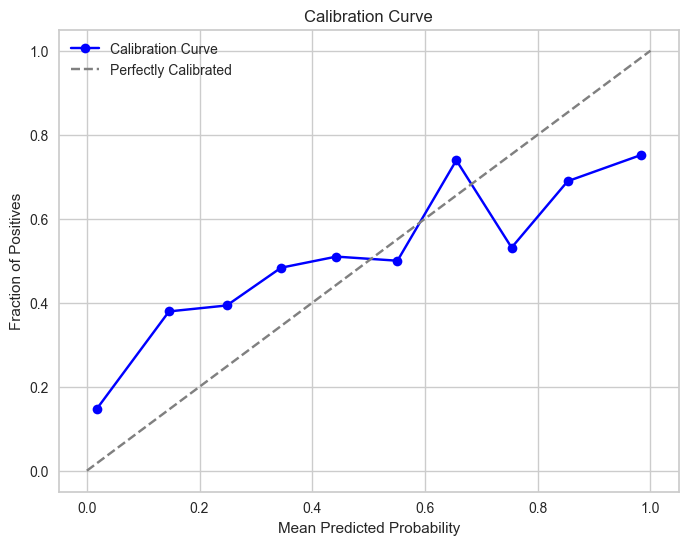

In [10]:
# Calibration Curve for Naive Bayes Model
from sklearn.calibration import calibration_curve

probabilities = naive_bayes_model.predict_proba(X_test)[:, 1]

prob_true, prob_pred = calibration_curve(y_test, probabilities, n_bins=10, strategy='uniform')

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

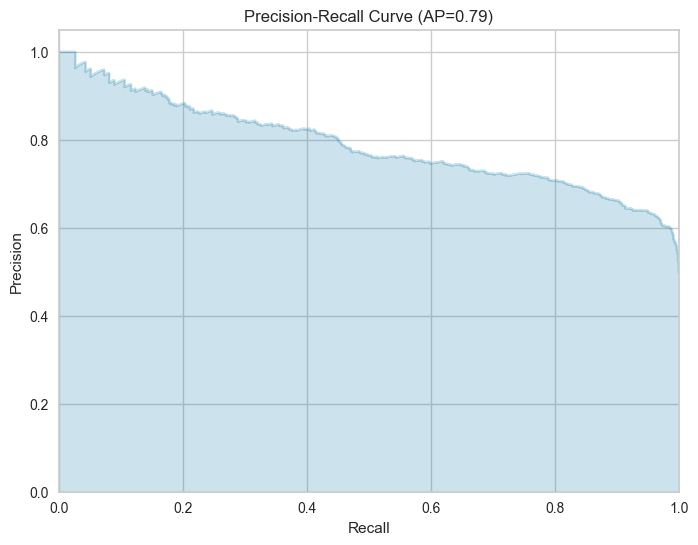

In [11]:
y_scores = naive_bayes_model.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Calculate the average precision
average_precision = average_precision_score(y_test, y_scores)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve (AP={round(average_precision,2)})')
plt.show()

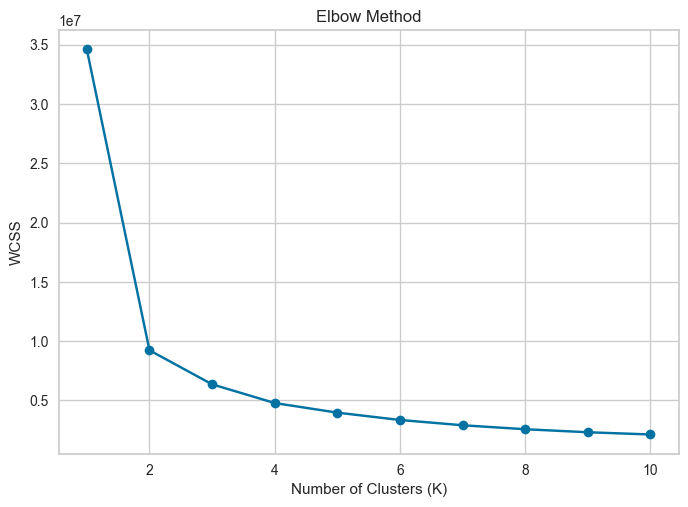

In [18]:
# 4 - K-Means Model

# Selecting number of clusters from Elbow Plot
wcss = [] 

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_resampled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker = 'o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.show()

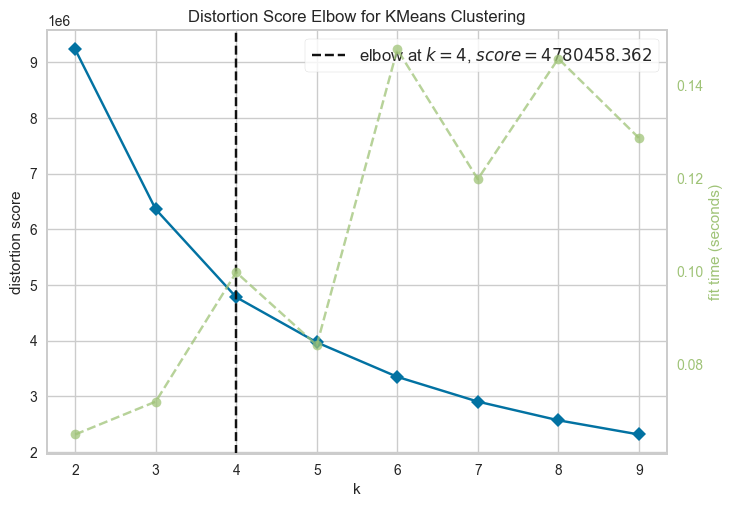

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
# Selecting number of clusters from Elbow Plot and Gap Statistics Method
visualizer = KElbowVisualizer(kmeans, k=(2, 10)) 

visualizer.fit(X_resampled)

visualizer.poof()

In [21]:
# Appyling K-Means Model taking 4 Clusters
kmeans_model = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)

kmeans_model.fit(X_resampled)
labels = kmeans_model.predict(X_resampled)

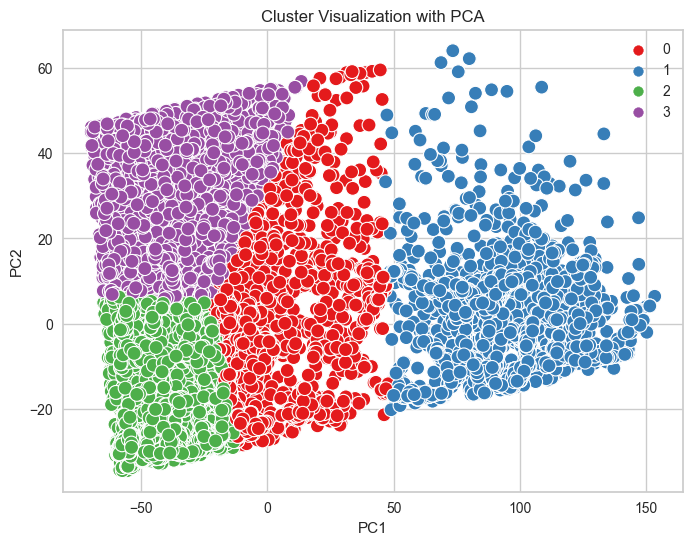

In [22]:
# Visualizaing the clusters
pca = PCA(n_components=2)

# Fit and transform your data using PCA
X_pca = pca.fit_transform(X_resampled)

X_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
X_pca['cluster'] = labels

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=X_pca, hue='cluster', palette='Set1', s=100)
plt.title('Cluster Visualization with PCA')
plt.legend()
plt.show()

In [23]:
# 5 - KNN Model
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn_model = KNeighborsClassifier(n_neighbors=2)

knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('***K-Nearest Neighbour***\n')
print(f'Accuracy: {round(accuracy,4)}')
print(f'Precision: {round(precision,4)}')
print(f'Recall: {round(recall,4)}')
print(f'F1-score: {round(f1,4)}')
print(f'Confusion matrix:\n {cm}')

***K-Nearest Neighbour***

Accuracy: 0.9316
Precision: 0.9291
Recall: 0.9339
F1-score: 0.9315
Confusion matrix:
 [[907  69]
 [ 64 904]]


In [24]:
#Verifying accuracy on diffrent subset of data to notice variation of accuracy.
model_knn_cv = KNeighborsClassifier(n_neighbors=2)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model_knn_cv, X_resampled, y_resampled, cv=kf, scoring='accuracy')

for fold, score in enumerate(cross_val_scores, start=1):
    print(f'Cross-Validation Fold {fold}: Accuracy = {round(score,4)}')
    
mean_score = cross_val_scores.mean()
std_deviation = cross_val_scores.std()
print(f'\nMean Accuracy: {round(mean_score,4)}')
print(f'Standard Deviation: {round(std_deviation,4)}')

Cross-Validation Fold 1: Accuracy = 0.9228
Cross-Validation Fold 2: Accuracy = 0.93
Cross-Validation Fold 3: Accuracy = 0.9383
Cross-Validation Fold 4: Accuracy = 0.9198
Cross-Validation Fold 5: Accuracy = 0.9342
Cross-Validation Fold 6: Accuracy = 0.9187
Cross-Validation Fold 7: Accuracy = 0.9187
Cross-Validation Fold 8: Accuracy = 0.9146
Cross-Validation Fold 9: Accuracy = 0.9321
Cross-Validation Fold 10: Accuracy = 0.9198

Mean Accuracy: 0.9249
Standard Deviation: 0.0076


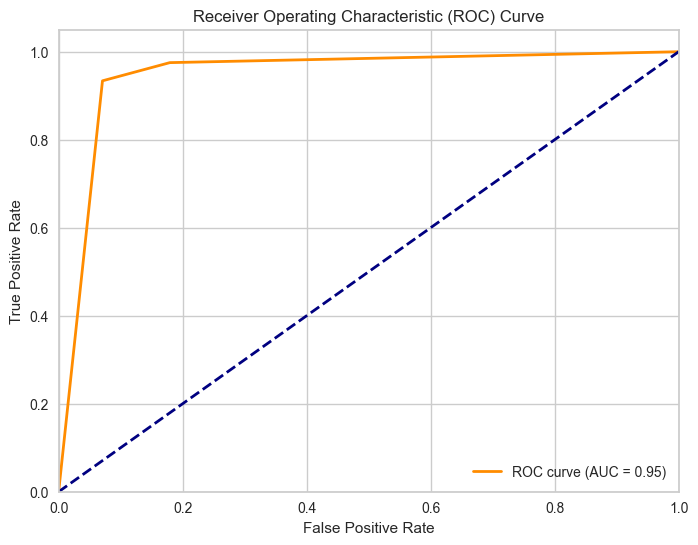

In [25]:
# Visualizing ROC Curve for the model
y_scores = knn_model.predict_proba(X_test)[:, 1]  

fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
